In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency

In [19]:
# Modern violet gradient color palette
COLORS = {
    'primary': '#667eea',
    'secondary': '#764ba2',
    'accent': '#f093fb',
    'highlight': '#4facfe',
    'dark': '#2d3561',
    'light': '#e0c3fc'
}

GRADIENT = ['#667eea', '#764ba2', '#a855f7', '#f093fb', '#fbc2eb']

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(GRADIENT)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10


In [ ]:
train = pd.read_csv('./data/playground-series-s6e2/train.csv')
test = pd.read_csv('./data/playground-series-s6e2/test.csv')

print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")

Train Shape: (630000, 15)
Test Shape: (270000, 14)


In [6]:
print("=" * 80)
print("TRAIN DATA - FIRST 5 ROWS")
print("=" * 80)
display(train.head())

print("\n", "=" * 80)
print("TEST DATA - FIRST 5 ROWS")
print("=" * 80)
display(test.head())

TRAIN DATA - FIRST 5 ROWS


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence



TEST DATA - FIRST 5 ROWS


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,630000,58,1,3,120,288,0,2,145,1,0.8,2,3,3
1,630001,55,0,2,120,209,0,0,172,0,0.0,1,0,3
2,630002,54,1,4,120,268,0,0,150,1,0.0,2,3,7
3,630003,44,0,3,112,177,0,0,168,0,0.9,1,0,3
4,630004,43,1,1,138,267,0,0,163,0,1.8,2,0,7


In [7]:
print("=" * 80)
print("TRAIN DATA - INFO")
print("=" * 80)
train.info()

TRAIN DATA - INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 non-null 

In [8]:
TARGET = "Heart Disease"
ID_COL = "id"

train_cols = [col for col in train.columns if col not in [ID_COL, TARGET]]
test_cols = [col for col in test.columns if col not in [ID_COL]]

print(f"Target Variable: {TARGET}")
print(f"Number of Features: {len(train_cols)}")
print("\nFeature List: ")
for i, col in enumerate(train_cols, 1):
    print(f"   {i:2d}. {col}")

CATS = train[train_cols].select_dtypes(include=["object"]).columns.tolist()
NUMS = train[train_cols].select_dtypes(exclude=["object"]).columns.tolist()

print("\n", "="*80)
print(f"Categorical Features ({len(CATS)}): {CATS}")
print(f"Numerical Features ({len(NUMS)}): {NUMS}")

Target Variable: Heart Disease
Number of Features: 13

Feature List: 
    1. Age
    2. Sex
    3. Chest pain type
    4. BP
    5. Cholesterol
    6. FBS over 120
    7. EKG results
    8. Max HR
    9. Exercise angina
   10. ST depression
   11. Slope of ST
   12. Number of vessels fluro
   13. Thallium

Categorical Features (0): []
Numerical Features (13): ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium']


### 1. Basic Data Quality Checks

In [9]:
def check_missing_values(df, name):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing Count': missing.values,
        'Missing Percentage': missing_pct.values
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

    print(f'\n{"="*80}')
    print(f"{name} - MISSING VALUES ANALYSIS")
    print(f"{'='*80}")

    if len(missing_df) == 0:
        print("✓ No missing values found in the dataset.")
    else:
        display(missing_df)

    return missing_df

In [10]:
train_missing = check_missing_values(train, "TRAIN")
test_missing = check_missing_values(test, "TEST")


TRAIN - MISSING VALUES ANALYSIS
✓ No missing values found in the dataset.

TEST - MISSING VALUES ANALYSIS
✓ No missing values found in the dataset.


Duplicate Rows Check

In [11]:
print("="*80)
print("DUPLICATE ROWS CHECK")
print("="*80)

train_duplicates = train.duplicated().sum()
test_duplicates = test.duplicated().sum()

print(f"Train Duplicates: {train_duplicates: ,} ({train_duplicates / len(train) * 100:.2f}%)")
print(f"Test Duplicates: {test_duplicates: ,} ({test_duplicates / len(test) * 100:.2f}%)")

DUPLICATE ROWS CHECK
Train Duplicates:  0 (0.00%)
Test Duplicates:  0 (0.00%)


Unique Values Count

In [13]:
print("="*80)
print("UNIQUE VALUES COUNT - ALL FEATURES")
print("="*80)

unique_counts = pd.DataFrame({
    'Feature': train_cols,
    'Train Unique': [train[col].nunique() for col in train_cols],
    'Test Unique': [test[col].nunique() for col in train_cols],
    'Train Sample Size': len(train),
    'Cardinality Ratio': [train[col].nunique() / len(train) * 100 for col in train_cols]
})

unique_counts = unique_counts.sort_values('Train Unique', ascending=False)
display(unique_counts)

UNIQUE VALUES COUNT - ALL FEATURES


,Feature,Train Unique,Test Unique,Train Sample Size,Cardinality Ratio
4,Cholesterol,150,145,630000,0.023810
7,Max HR,93,92,630000,0.014762
3,BP,66,64,630000,0.010476
9,ST depression,66,64,630000,0.010476
0,Age,42,43,630000,0.006667
2,Chest pain type,4,4,630000,0.000635
11,Number of vessels fluro,4,4,630000,0.000635
6,EKG results,3,3,630000,0.000476
10,Slope of ST,3,3,630000,0.000476
12,Thallium,3,3,630000,0.000476


Statistical Summary - Numerical Features

In [18]:
print("="*80)
print("STATISTICAL SUMMARY - NUMERICAL FEATURES (TRAIN)")
print("="*80)

display(train[NUMS].describe().T.style.background_gradient(cmap='viridis'))


STATISTICAL SUMMARY - NUMERICAL FEATURES (TRAIN)


,count,mean,std,min,25%,50%,75%,max
Age,630000.000000,54.136706,8.256301,29.000000,48.000000,54.000000,60.000000,77.000000
Sex,630000.000000,0.714735,0.451541,0.000000,0.000000,1.000000,1.000000,1.000000
Chest pain type,630000.000000,3.312752,0.851615,1.000000,3.000000,4.000000,4.000000,4.000000
BP,630000.000000,130.497433,14.975802,94.000000,120.000000,130.000000,140.000000,200.000000
Cholesterol,630000.000000,245.011814,33.681581,126.000000,223.000000,243.000000,269.000000,564.000000
FBS over 120,630000.000000,0.079987,0.271274,0.000000,0.000000,0.000000,0.000000,1.000000
EKG results,630000.000000,0.981660,0.998783,0.000000,0.000000,0.000000,2.000000,2.000000
Max HR,630000.000000,152.816763,19.112927,71.000000,142.000000,157.000000,166.000000,202.000000
Exercise angina,630000.000000,0.273725,0.445870,0.000000,0.000000,0.000000,1.000000,1.000000
ST depression,630000.000000,0.716028,0.948472,0.000000,0.000000,0.100000,1.400000,6.200000


### 2. Target Variable Analysis
Target Distribution

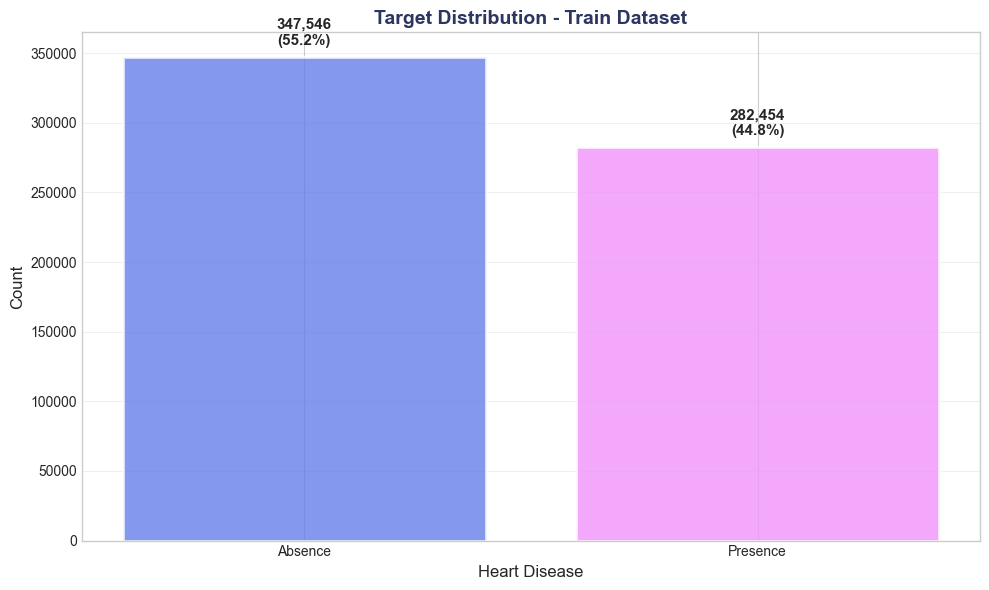

CLASS BALANCE ANALYSIS

Train Dataset: 
   Absence: 347,546 (55.17%)
   Presence: 282,454 (44.83%)

Imbalance Ratio: 1.23:1
✓ Classes are relatively balanced.


In [29]:
plt.figure(figsize=(10, 6))

target_counts_train = train[TARGET].value_counts().sort_index()
colors_train = [COLORS['primary'], COLORS["accent"]]
plt.bar(target_counts_train.index, target_counts_train.values, color=colors_train, alpha=0.8, edgecolor='white', linewidth=2)
plt.title("Target Distribution - Train Dataset", fontsize=14, fontweight='bold', color=COLORS['dark'])
plt.xlabel(TARGET, fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', alpha=0.3)

for i, (value, count) in enumerate(target_counts_train.items()):
    pct = count / len(train) * 100
    plt.text(i, count + len(train)*0.01, f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("="*80)
print("CLASS BALANCE ANALYSIS")
print("="*80)
print(f"\nTrain Dataset: ")
for label, count in target_counts_train.items():
    print(f"   {label}: {count:,} ({count / len(train) * 100:.2f}%)")

imbalance_ratio = target_counts_train.max() / target_counts_train.min()
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 1.5:
    print("⚠ Moderate class imbalance detected. Consider stratified CV and balanced metrics.")
elif imbalance_ratio > 2.0:
    print("⚠⚠ Significant class imbalance detected. Consider SMOTE or class weights.")
else:
    print("✓ Classes are relatively balanced.")


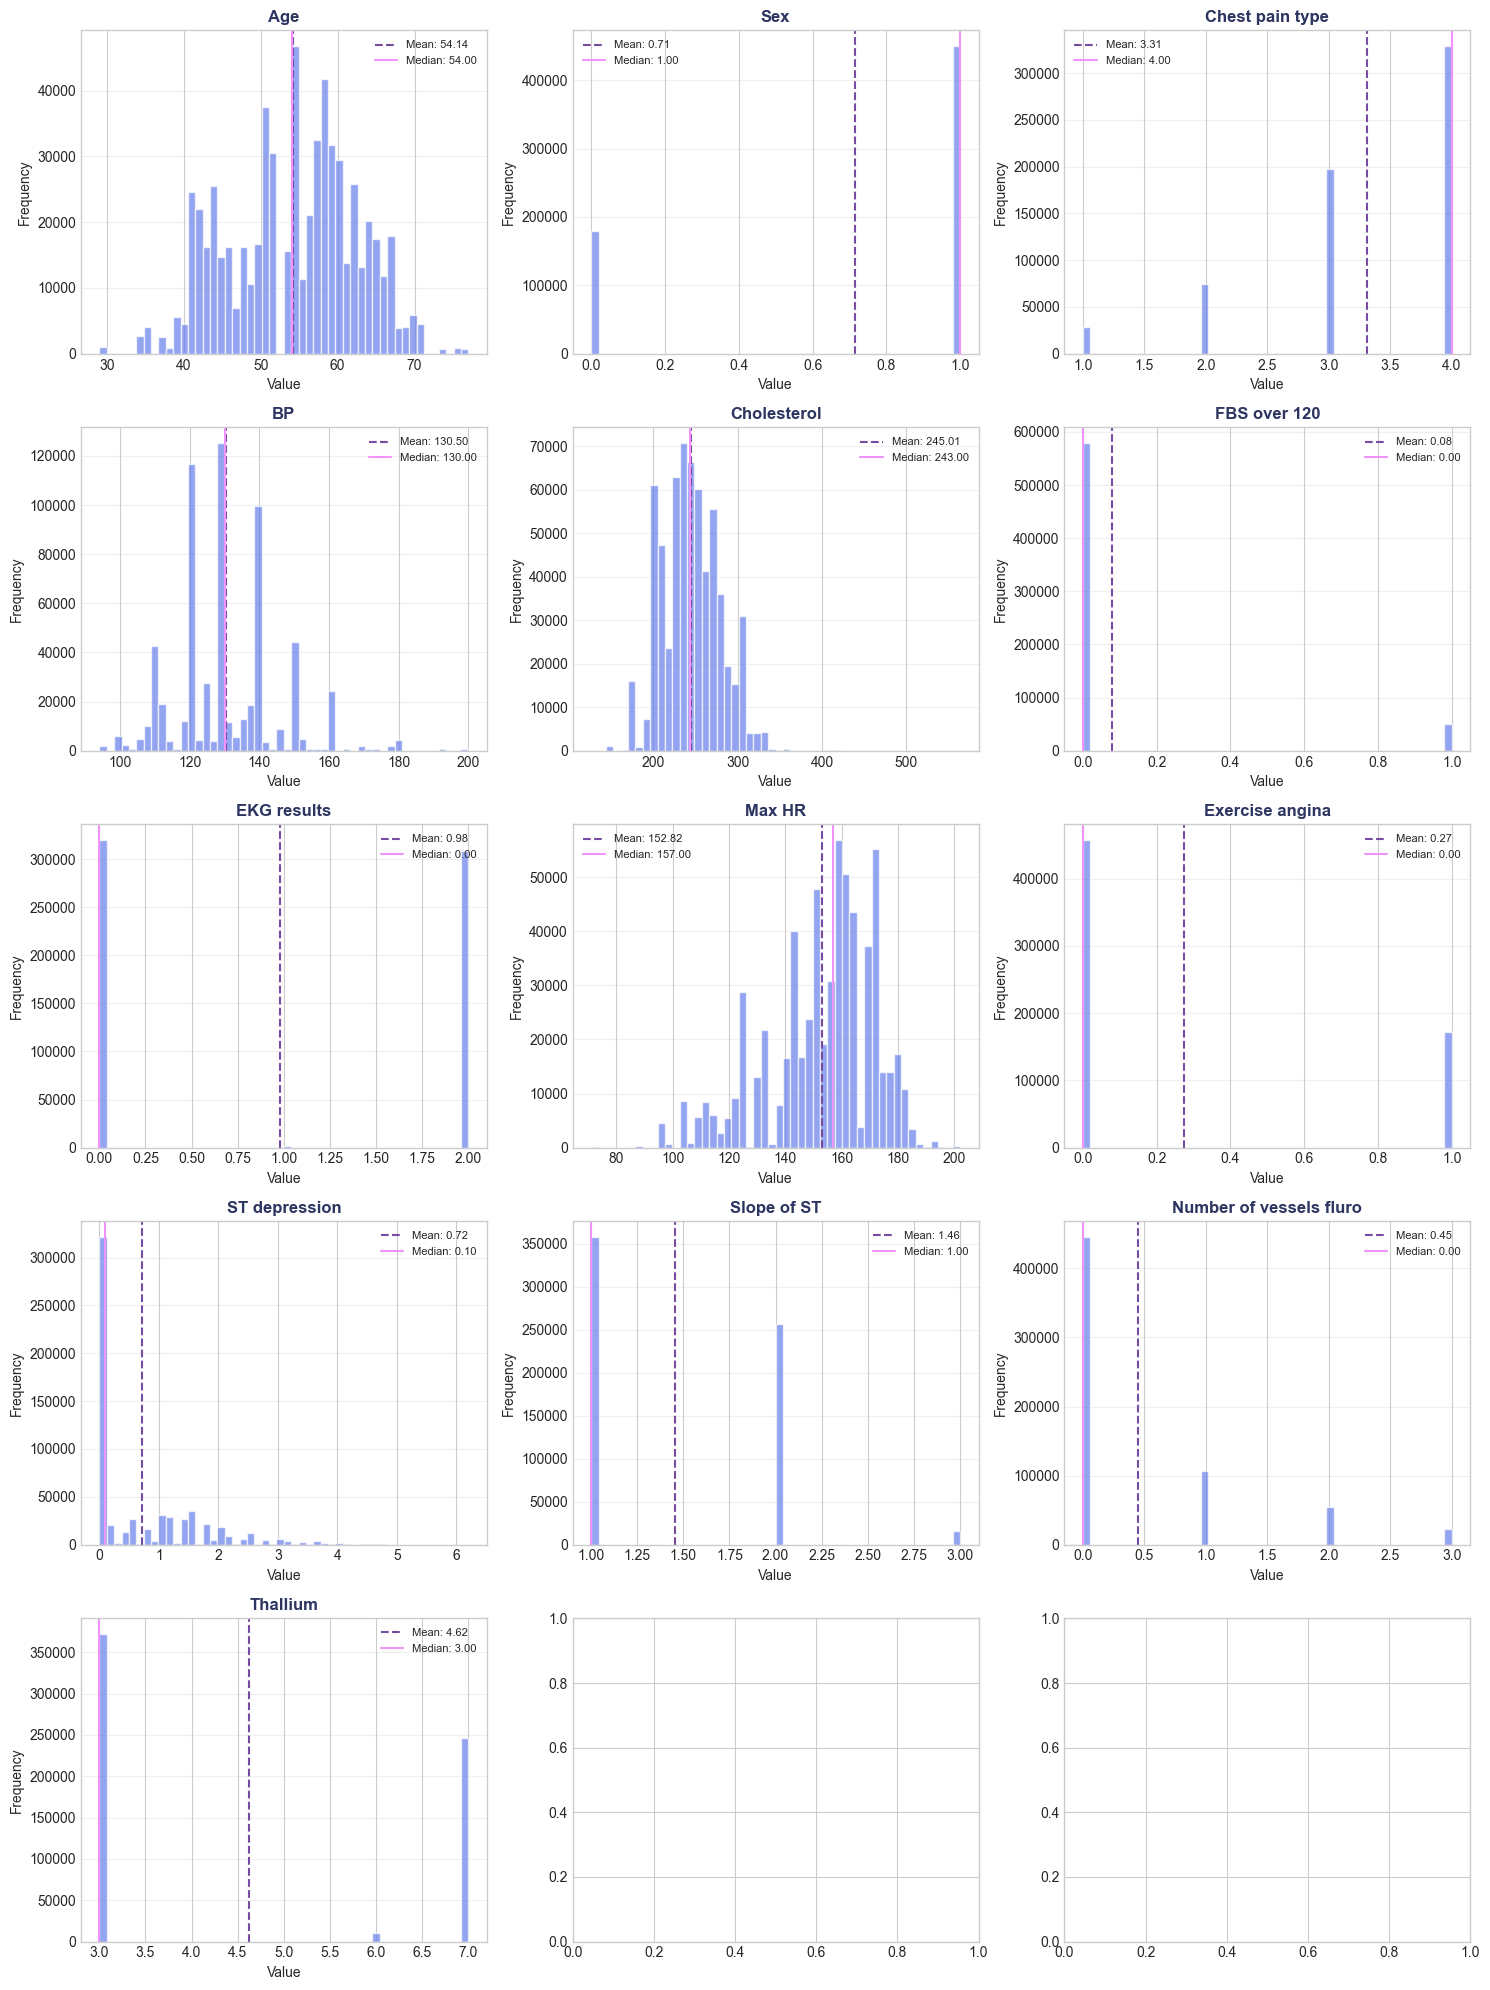

In [33]:
n_cols = 3
n_rows = (len(NUMS) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMS):
    axes[i].hist(train[col], bins=50, color=COLORS['primary'], alpha=0.7, edgecolor='white')
    axes[i].set_title(f"{col}", fontsize=12, fontweight='bold', color=COLORS['dark'])
    axes[i].set_xlabel('Value', fontsize=10)
    axes[i].set_ylabel("Frequency", fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)

    mean_val = train[col].mean()
    median_val = train[col].median()
    axes[i].axvline(mean_val, color=COLORS['secondary'], linestyle='--', label=f"Mean: {mean_val:.2f}")
    axes[i].axvline(median_val, color=COLORS['accent'], linestyle='-', label=f"Median: {median_val:.2f}")
    axes[i].legend(fontsize=8)
plt.tight_layout()

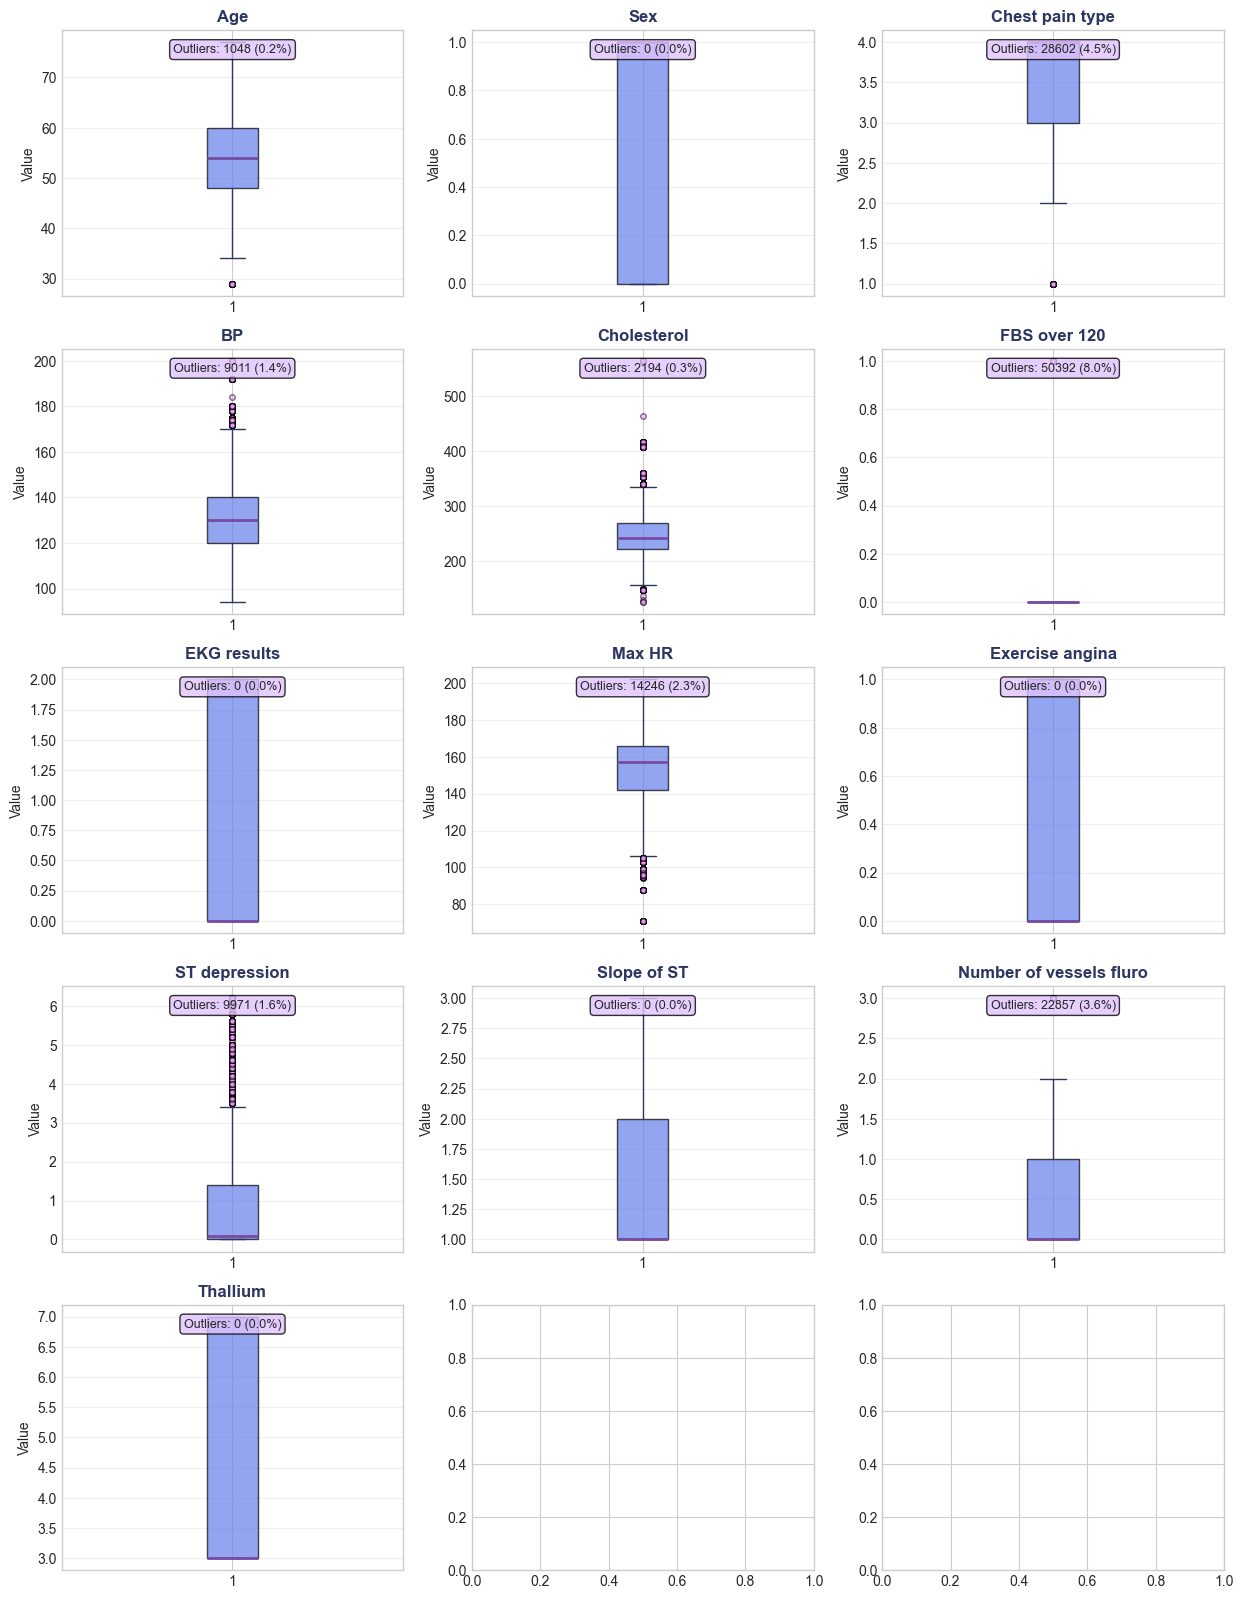

In [37]:
n_cols = 3
n_rows = (len(NUMS) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMS):
    bp = axes[i].boxplot(train[col], vert=True, patch_artist=True, boxprops=dict(facecolor=COLORS['primary'], alpha=0.7),
                        medianprops=dict(color=COLORS['secondary'], linewidth=2),
                        whiskerprops=dict(color=COLORS['dark']),
                        capprops=dict(color=COLORS['dark']),
                        flierprops=dict(marker='o', markerfacecolor=COLORS['accent'], markersize=4, alpha=0.5))
    
    axes[i].set_title(f'{col}', fontsize=12, fontweight='bold', color=COLORS['dark'])
    axes[i].set_ylabel("Value", fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)
    
    q1 = train[col].quantile(0.25)
    q3 = train[col].quantile(0.75)
    iqr = q3 - q1
    outliers = ((train[col] < (q1 - 1.5 * iqr)) | (train[col] > (q3 + 1.5 * iqr))).sum()
    outlier_pct = outliers / len(train) * 100

    axes[i].text(0.5, 0.95, f'Outliers: {outliers} ({outlier_pct:.1f}%)', transform=axes[i].transAxes, ha='center', va='top', bbox=dict(boxstyle='round', facecolor=COLORS['light'], alpha=0.8), fontsize=9)

In [ ]:
skew_kurt_df = pd.DataFrame({
    'Feature': NUMS,
    'Skewness': [train[col].skew() for col in NUMS],
    'Kurtosis': [train[col].kurtosis() for col in NUMS],
    'Mean': [train[col].mean() for col in NUMS],
    'Std': [train[col].std() for col in NUMS]
})

skew_kurt_df['Skew_Type'] = skew_kurt_df['Skewness'].apply(lambda x: 'Highly Right' if x > 1 else ('Right' if x > 0.5 else ('Symmetric' if abs(x) <= 0.5 else ('Left' if x < -0.5 else 'Highly Left'))))

skew_kurt_df = skew_kurt_df.sort_values('Skewness', key=abs, ascending=False)

print('='*80)
print('SKEWNESS AND KURTOSIS ANALYSIS')
print('='*80)
display(skew_kurt_df.style.background_gradient(cmap='coolwarm'))

print("\nInterpretation:")
print("  • Skewness > 1 or < -1: Highly skewed (consider log transform)")
print("  • Skewness between -0.5 and 0.5: Approximately symmetric")
print("  • Kurtosis > 3: Heavy tails (more outliers)")
print("  • Kurtosis < 3: Light tails (fewer outliers)")

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
629995,56,0,1,110,226,0,0,132,0,0.0,1,0,7
629996,54,1,4,128,249,1,2,150,0,0.0,2,0,3
629997,67,1,4,130,275,0,0,149,0,0.0,1,2,7
629998,52,1,4,140,199,0,2,157,0,0.0,1,0,6


In [40]:
print('='*80)
print('STATISTICAL SIGNIFICANCE TEST (Numerical Features vs Target)')
print('='*80)
print("\nUsing Mann-Whitney U Test (non-parametric)")
print("H0: The distribution are the same")
print("H1: The distributions are different")
print(f"Significance Level: ⍺ = 0.05\n")

significance_results = []

for col in NUMS:
    groups = [train[train[TARGET] == val][col].values for val in sorted(train[TARGET].unique())]

    if len(groups) == 2:
        stat, p_value = stats.mannwhitneyu(groups[0], groups[1], alternative='two-sided')

        significance_results.append({
            'Feature': col,
            'Test_Statistic': stat,
            'P_Value': p_value,
            'Significant': "Yes" if p_value < 0.05 else "No",
            "Effect": "Strong" if p_value < 0.01 else ("Moderate" if p_value < 0.05 else "Weak")
        })

sig_df = pd.DataFrame(significance_results).sort_values('P_Value')
display(sig_df.style.background_gradient(cmap='RdYlGn_r'))

print(f"\nSignificant Features (p < 0.05): {sig_df[sig_df['Significant'] == 'Yes'].shape[0]}/{len(NUMS)}")


STATISTICAL SIGNIFICANCE TEST (Numerical Features vs Target)

Using Mann-Whitney U Test (non-parametric)
H0: The distribution are the same
H1: The distributions are different
Significance Level: ⍺ = 0.05



,Feature,Test_Statistic,P_Value,Significant,Effect
0,Age,36747944418.500000,0.000000,Yes,Strong
1,Sex,33821991183.000000,0.000000,Yes,Strong
2,Chest pain type,22747841890.500000,0.000000,Yes,Strong
4,Cholesterol,43889513411.000000,0.000000,Yes,Strong
6,EKG results,38268651767.000000,0.000000,Yes,Strong
7,Max HR,74204284951.500000,0.000000,Yes,Strong
8,Exercise angina,29638821411.000000,0.000000,Yes,Strong
9,ST depression,26143741179.500000,0.000000,Yes,Strong
10,Slope of ST,28023624776.500000,0.000000,Yes,Strong
11,Number of vessels fluro,27992132670.500000,0.000000,Yes,Strong



Significant Features (p < 0.05): 12/13
